<a href="https://colab.research.google.com/github/EddieCarrera/tinyML-workspace/blob/working-branch/ch4_pico_tinyML_helloWorld_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train a Simple TensorFlow Lite for Microcontrollers model

This notebook demonstrates the process of training a 2.5 kB model using TensorFlow and converting it for use with TensorFlow Lite for Microcontrollers.

Deep learning networks learn to model patterns in underlying data. Here, we're going to train a network to model data generated by a [sine](https://en.wikipedia.org/wiki/Sine) function. This will result in a model that can take a value, `x`, and predict its sine, `y`.


##  Setup Enviroment

In [ ]:
# Install tensorflow
! pip install tensorflow;

# Define paths to model files
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'



In [ ]:
# Install modules
# TensorFlow is an open source machine learning library
import tensorflow as tf
# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras
# Numpy is a math library
import numpy as np
# Pandas is a data manipulation library
import pandas as pd
# Matplotlib is a graphing library
import matplotlib.pyplot as plt
# Math is Python's math library
import math

# Set seed for experiment reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)



## Dataset

### Generate Data

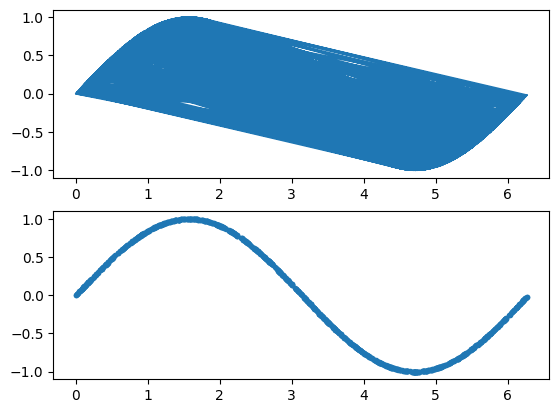

In [ ]:
# Create a sine wave fed by random x values
samples  = 1000;

# typecast to float32 required for converter.convert() when creating the TF model
x_values = np.random.uniform(
    low = 0, high = 2*np.pi, size = samples).astype(np.float32)

# Second, after generating the data, we shuffle it. This is important because
# the training process used in deep learning depends on data being fed to it in
# a truly random order. If the data were in order, the resulting model would be
# less accurate.
np.random.shuffle(x_values)

# The first subplot is meant to show that the x values are indeed out of
# order
y_values = np.sin(x_values)
fig, axs = plt.subplots(2)
axs[0].plot(x_values, y_values)
axs[1].plot(x_values, y_values, '.')

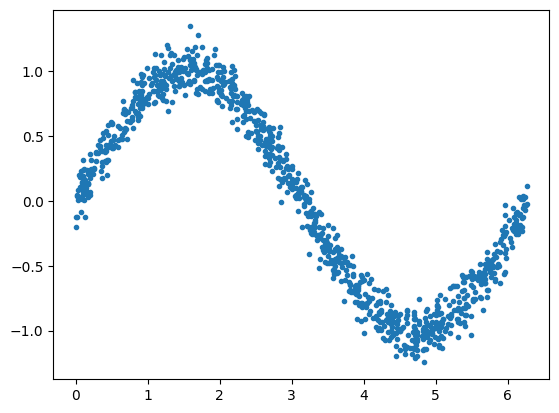

In [ ]:
# Now add noise to simulate real world
gaussian_mean = 0
gaussian_std = 0.1
y_values += np.random.normal(gaussian_mean, gaussian_std, samples)
plt.plot(x_values, y_values, '.')

### Splitting the Data

We now have a noisy dataset that approximates real world data. We'll be using this to train our model.

To evaluate the accuracy of the model we train, we'll need to compare its predictions to real data and check how well they match up. This evaluation happens during training (where it is referred to as validation) and after training (referred to as testing) It's important in both cases that we use fresh data that was not already used to train the model.

The data is split as follows:

1. Training: 70%
2. Validation: 20%
3. Testing: 10%

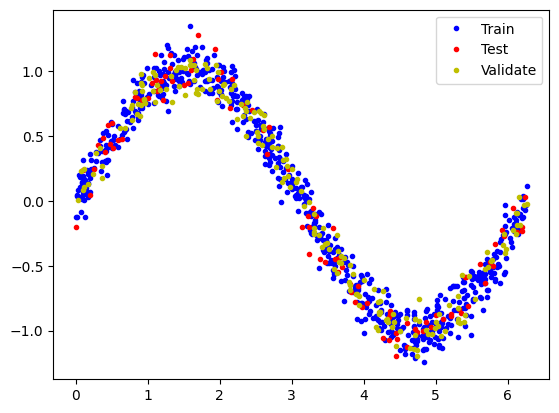

In [ ]:
training_size = int(0.7*samples)
validation_size = int(0.2*samples)
trainingIdx = training_size
validationIdx = trainingIdx + validation_size

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train, x_valid, x_test = np.split(x_values, [trainingIdx, validationIdx])
y_train, y_valid, y_test = np.split(y_values, [trainingIdx, validationIdx])

assert(x_train.size + x_valid.size + x_test.size == samples)

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_valid, y_valid, 'y.', label="Validate")
plt.legend()
plt.show()


## Training

### Defining a Basic Model

We're going to build a simple neural network model that will take an input value (in this case, `x`) and use it to predict a numeric output value (the sine of `x`). This type of problem is called a **regression**. It will use _layers_ of _neurons_ to attempt to learn any patterns underlying the training data, so it can make predictions. We can use regression models for all sorts of tasks that require a numeric output. For example, a regression model could attempt to predict a person’s running speed in miles per hour based on data from an accelerometer.

To begin with, we'll define two layers. The first layer takes a single input (our `x` value) and runs it through 8 neurons. Based on this input, each neuron will become _activated_ to a certain degree based on its internal state (its _weight_ and _bias_ values). A neuron's degree of activation is expressed as a number.

The activation numbers from our first layer will be fed as inputs to our second layer, which is a single neuron. It will apply its own weights and bias to these inputs and calculate its own activation, which will be output as our `y` value.

The code in the following cell defines our model using [Keras](https://www.tensorflow.org/guide/keras), TensorFlow's high-level API for creating deep learning networks. Once the network is defined, we _compile_ it, specifying parameters that determine how it will be trained:

#### Key Terms & Explanations

1. A **sequential** model is initialized, which just means a model in which each layer of neurons is stacked on top of the next.

2. The first layer has a single input—our x value—and 8 neurons. It’s a **dense** layer (also known as a fully connected layer), meaning the input will be fed into every single one of its neurons during inference, when we’re making predictions. Each neuron will then become activated to a certain degree. The amount of activation for each neuron is based on both its weight and bias values, learned during training, and its activation function. The neuron’s activation is output as a number.

3. An **activation function** is calulated as follows:
```
activation = activation_function((input * weight) + bias)
```
  The activation function is a mathematical function used to shape the output of the neuron. In our network, we’re using an activation function called **rectified linear unit**, or **ReLU** for short. This is specified in Keras by the argument `activation=relu.`

  Without an activation function, the neuron’s output would always be a linear function of its input. This would mean that the network could model only linear relationships in which the ratio between x and y remains the same across the entire range of values. This would prevent a network from modeling our sine wave, because a sine wave is nonlinear.

  Since ReLU is nonlinear, it allows multiple layers of neurons to join forces and model complex nonlinear relationships, in which the y value doesn’t increase by the same amount for every increment of x.

  <ins>Note:</ins>
  
  There are other activation functions, but ReLU is the most commonly used. You can see some of the other options in the [Wikipedia article on activation functions.](https://www.wikiwand.com/en/Activation_function#Comparison_of_activation_functions) Each activation function has different trade-offs, and machine learning engineers experiment to find which options work best for a given architecture.

4. **ReLU** is a simple function defined by:
```
def relu(input):
return max(0.0, input)
```
  ReLU returns whichever is the larger value: its input, or zero. If its input value is negative, ReLU returns zero. If its input value is above zero, ReLU returns it unchanged.


In [ ]:
# We'll use Keras to create a simple model architecture
model_1 = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 8 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model_1.add(keras.layers.Dense(8, activation='relu', input_shape=(1,)))


5. The activation numbers from our first layer will be fed as inputs to our second layer, which is defined in the following line: `model_1.add(keras.layers.Dense(1))`. Because this layer is a single neuron, it will receive 8 inputs, one for each of the neu‐ rons in the previous layer. Its purpose is to combine all of the activations from the previous layer into a single output value. Since this is our output layer, we don’t specify an activation function—we just want the raw result.

  Because this neuron has multiple inputs, it has a corresponding weight value for each. The neuron’s output is calculated by the following formula, shown in Python:
 ```
output = sum((inputs * weights)) + bias
 ```
The network’s weights and biases are learned during training. The `compile()` step in the code shown earlier in the chapter configures some important arguments used in the training process, and prepares the model to be trained.

6. The `optimizer` argument specifies the algorithm that will adjust the network to model its input during training. <ins>There are several choices, and finding the best one often comes down to experimentation.</ins> You can read about the options in the [Keras documentation](https://keras.io/api/optimizers/).

7. The `loss` argument specifies the method used during training to calculate how far the network’s predictions are from reality. This method is called a loss function. Here, we’re using **mse, or mean squared error.** This loss function is used in the case of regression problems, for which we’re trying to predict a number. There are various loss functions available in Keras. [You can see some of the options listed in the Keras docs.](https://keras.io/api/losses/).

8. The `metrics` argument allows us to specify some additional functions that are used to judge the performance of our model. We specify **mae, or mean absolute error**, which is a helpful function for measuring the performance of a regression model. This metric will be measured during training, and we’ll have access to the results after training is done.


In [ ]:
# Final layer is a single neuron, since we want to output a single value
model_1.add(keras.layers.Dense(1))

# Compile the model using the standard 'adam' optimizer and the mean squared error or 'mse' loss function for regression.
model_1.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print a summary of the model's architecture
model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 8)                 16        
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 25 (100.00 Byte)
Trainable params: 25 (100.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Training the Model

After we define our model, it’s time to train it and then evaluate its performance to
see how well it works. When we see the metrics, we can decide if it’s good enough, or
if we should make changes to our design and train it again.

To train a model in Keras we just call its `fit()` method, passing all of our data and
some other important arguments. The code in the next cell shows how:

In [ ]:
# Train the model on our training data while validating on our validation set
history_1 = model_1.fit(x_train, y_train, epochs=500, batch_size=64,
                        validation_data=(x_valid, y_valid))

Epoch 1/500
11/11 [==============================] - 1s 32ms/step - loss: 0.6078 - mae: 0.6957 - val_loss: 0.5659 - val_mae: 0.6835
Epoch 2/500
11/11 [==============================] - 0s 6ms/step - loss: 0.5336 - mae: 0.6511 - val_loss: 0.5202 - val_mae: 0.6511
Epoch 3/500
11/11 [==============================] - 0s 6ms/step - loss: 0.4840 - mae: 0.6151 - val_loss: 0.4949 - val_mae: 0.6296
Epoch 4/500
11/11 [==============================] - 0s 7ms/step - loss: 0.4585 - mae: 0.5929 - val_loss: 0.4780 - val_mae: 0.6136
Epoch 5/500
11/11 [==============================] - 0s 8ms/step - loss: 0.4378 - mae: 0.5741 - val_loss: 0.4631 - val_mae: 0.6012
Epoch 6/500
11/11 [==============================] - 0s 7ms/step - loss: 0.4223 - mae: 0.5601 - val_loss: 0.4492 - val_mae: 0.5899
Epoch 7/500
11/11 [==============================] - 0s 7ms/step - loss: 0.4078 - mae: 0.5480 - val_loss: 0.4356 - val_mae: 0.5800
Epoch 8/500
11/11 [==============================] - 0s 21ms/step - loss: 0.3948 -

#### Key Terms & Explainations

**x_train/y_train:**

The first two arguments to fit() are the x and y values of our training data. Remember that parts of our data are kept aside for validation and testing, so only the training set is used to train the network.

**epochs:**

The next argument specifies how many times our entire training set will be run through the network during training. The more epochs, the more training will occur. You might think that the more training happens, the better the network will be. However, some networks will start to overfit their training data after a certain number of epochs, so we might want to limit the amount of training we do.
In addition, even if there’s no overfitting, a network will stop improving after a certain amount of training. Since training costs time and computational resources, it’s best not to train if the network isn’t getting better! We’re starting out with 500 epochs of training. When training is complete, we can dig into our metrics to discover whether this is the correct number.

**batch_size:**

The batch_size argument specifies how many pieces of training data to feed into the network before measuring its accuracy and updating its weights and biases.

If we wanted, we could specify a batch_size of 1, meaning we’d run inference on a single datapoint, measure the loss of the network’s prediction, update the weights and biases to make the prediction more accurate next time, and then continue this cycle for the rest of the data.
Because we have 700 datapoints, each epoch would result in 700 updates to the network. This is a lot of computation, so our training would take ages! An alternative might be to select and run inference on multiple datapoints, measure the loss in aggregate, and then updating the network accordingly.

If we set batch_size to 700, each batch would include all of our training data. We’d now have to make only one update to the network every epoch — much quicker. The problem is, this results in less accurate models. Research has shown that models trained with large batch sizes have less ability to generalize to new data — they are more likely to overfit.

The compromise is to use a batch size that is somewhere in the middle. In our training code, we use a batch size of 64. This means that we’ll choose 64 data points at random, run inference on them, calculate the loss in aggregate, and update the network once per batch. If we have 700 points of training data, the network will be updated around 11 times per epoch, which is far better than 700.
When choosing a batch size, we’re making a compromise between training efficiency and model accuracy. The ideal batch size will vary from model to model. It’s a good idea to start with a batch size of 16 or 32 and experiment to see what works best.

**validation_data:**

This is where we specify our validation dataset. Data from this dataset will be run through the network throughout the training process, and the network’s predic‐ tions will be compared with the expected values. We’ll see the results of validation in the logs and as part of the history_1 object.


#### Training Metrics

We’re now going to check various metrics to see how well our network has learned. To begin, let’s look at the logs written during training. This will show how the network has improved during training from its random initial state.

Here are the logs for our first and last epochs:

```
Epoch 1/500
11/11 [==============================] - 2s 40ms/step - loss: 0.7697 - mae: 0.7751 - val_loss: 0.6477 - val_mae: 0.7281

Epoch 500/500
11/11 [==============================] - 0s 11ms/step - loss: 0.1450 - mae: 0.3006 - val_loss: 0.1474 - val_mae: 0.3029
```

**loss**

This is the output of our loss function. We’re using mean squared error, which is expressed as a positive number. Generally, the smaller the loss value, the better, so this is a good thing to watch as we evaluate our network.

Comparing the first and last epochs, the network has clearly improved during training, going from a loss of ~0.77 to a smaller value of ~0.15. Let’s look at the other numbers to see whether this improvement is enough!

**mae**

This is the mean absolute error of our training data. It shows the average difference between the network’s predictions and the expected y values from the training data.

We can expect our initial error to be pretty dismal, given that it’s based on an untrained network. This is certainly the case: the network’s predictions are off by an average of ~0.78, which is a large number when the range of acceptable values is only from –1 to 1!

However, even after training, our mean absolute error is ~0.30. This means that our predictions are off by an average of ~0.30, which is still quite awful.

**val_loss**

This is the output of our loss function on our validation data. <ins>In our final epoch, the training loss ~0.145 is slightly lower than the validation loss ~0.147. This is a hint that our network might be overfitting, because it is performing worse on data it has not seen before.</ins>

**val_mae**

This is the mean absolute error for our validation data. With a value of ~0.3, it’s worse than the mean absolute error on our training set, which is another sign that the network might be overfitting.

**overfitting**

When a model is overfit, it has learned its training data too well. The model is able to exactly predict the minutiae of its training data, but it is not able to generalize its learning to data it has not previously seen. Often this happens because the model has managed to entirely memorize the training data, or it has learned to rely on a shortcut present in the training data but not in the real world.

##### Graphing the Metrics

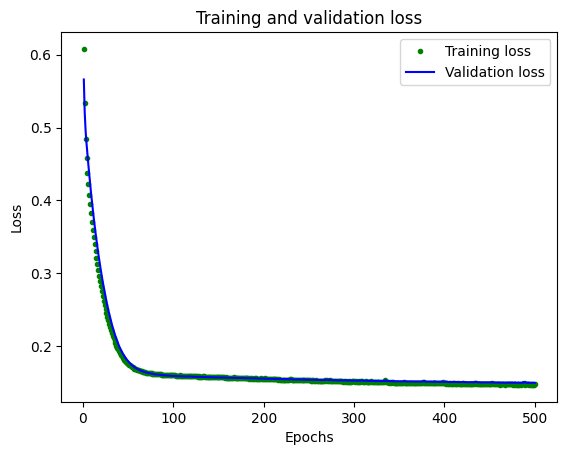

In [ ]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

As you can see, the amount of loss rapidly decreases over the first 50 epochs, before flattening out. This means that the model is improving and producing more accurate predictions.

Our goal is to stop training when either the model is no longer improving or the training loss is less than the validation loss, which would mean that the model has learned to predict the training data so well that it can no longer generalize to new data.

The loss drops precipitously in the first few epochs, which makes the rest of the graph quite difficult to read. Let’s skip the first 180 epochs by running the next cell:

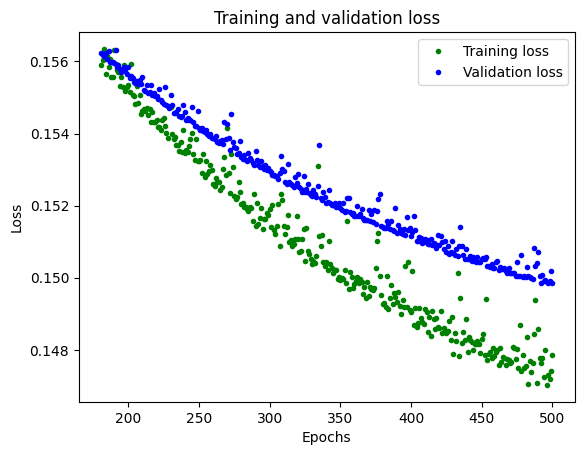

In [ ]:
# Exclude the first few epochs so the graph is easier to read
SKIP = 180

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

To gain more insight into our model's performance we can plot some more data. This time, we'll plot the mean absolute error, which is another way of measuring how far the network's predictions are from the actual numbers:

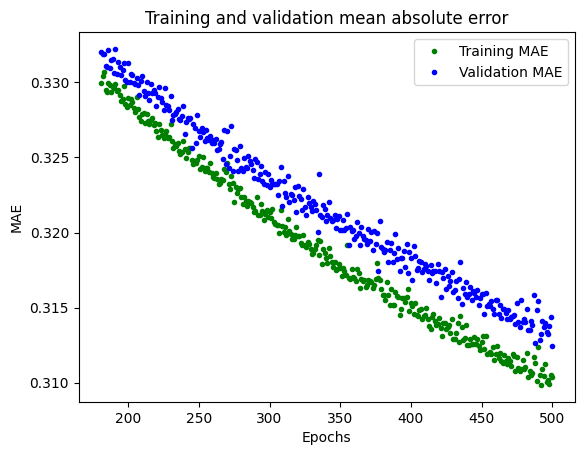

In [ ]:
plt.clf()

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_mae = history_1.history['mae']
val_mae = history_1.history['val_mae']

plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

This graph of **mean absolute error** tells another story. <ins>We can see that training data shows consistently lower error than validation data, which means that the network may have overfit, or learned the training data so rigidly that it can't make effective predictions about new data.</ins>

In addition, the mean absolute error values are quite high, ~0.33 at best, which means some of the model's predictions are at least 30% off. A 30% error means we are very far from accurately modelling the sine wave function.

4/4 [==============================] - 0s 4ms/step


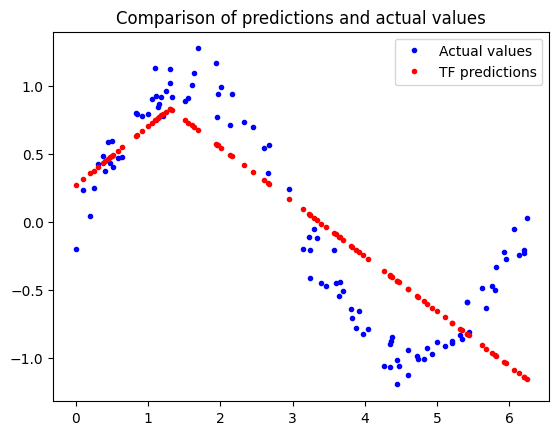

In [ ]:
# Calculate and print the loss on our test dataset
test_loss, test_mae = model_1.evaluate(x_test, y_test)

# Make predictions based on our test dataset
y_test_pred = model_1.predict(x_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual values')
plt.plot(x_test, y_test_pred, 'r.', label='TF predictions')
plt.legend()
plt.show()

Oh dear! The graph makes it clear that our network has learned to approximate the sine function in a very limited way.
The rigidity of this fit suggests that the model does not have enough capacity to learn the full complexity of the sine wave function, so it's only able to approximate it in an overly simplistic way. By making our model bigger, we should be able to improve its performance.

### Improving the Model

Armed with the knowledge that our original model was too small to learn the com‐ plexity of our data, we can try to make it better. This is a normal part of the machine learning workflow: design a model, evaluate its performance, and make changes in the hope of seeing improvement.

An easy way to make the network bigger is to add another layer of neurons. Each layer of neurons represents a transformation of the input that will hopefully get it closer to the expected output. The more layers of neurons a network has, the more complex these transformations can be.

To make our model bigger, let's add an additional layer of neurons. The following cell redefines our model in the same way as earlier, but with 16 neurons in the first layer and an additional layer of 16 neurons in the middle:

In [ ]:
model = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 16 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model.add(keras.layers.Dense(16, activation='relu', input_shape=(1,)))

# The new second and third layer will help the network learn more complex representations
model.add(keras.layers.Dense(16, activation='relu'))

# Final layer is a single neuron, since we want to output a single value
model.add(keras.layers.Dense(1))

# Compile the model using the standard 'adam' optimizer and the mean squared error or 'mse' loss function for regression.
model.compile(optimizer='adam', loss="mse", metrics=["mae"])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 16)                32        
                                                                 
 dense_13 (Dense)            (None, 16)                272       
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 321 (1.25 KB)
Trainable params: 321 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


With two layers of 16 neurons, our new model is a lot larger. It has (1 * 16) + (16 * 16) + (16 * 1) = 288 weights, plus 16 + 16 + 1 = 33 biases, for a total of 288 + 33 = 321 parameters. Our original model had only 49 total parameters, so this is a 555% increase in model size. Hopefully, this extra capacity will help represent the complexity of our data.

In [ ]:
# Train the model
history = model.fit(x_train, y_train, epochs=500, batch_size=64,
                    validation_data=(x_valid, y_valid))

# Save the model to disk
model.save(MODEL_TF)

Epoch 1/500
11/11 [==============================] - 1s 26ms/step - loss: 0.4397 - mae: 0.5797 - val_loss: 0.4354 - val_mae: 0.5812
Epoch 2/500
11/11 [==============================] - 0s 7ms/step - loss: 0.3880 - mae: 0.5264 - val_loss: 0.4118 - val_mae: 0.5579
Epoch 3/500
11/11 [==============================] - 0s 7ms/step - loss: 0.3629 - mae: 0.5072 - val_loss: 0.3807 - val_mae: 0.5426
Epoch 4/500
11/11 [==============================] - 0s 9ms/step - loss: 0.3396 - mae: 0.4929 - val_loss: 0.3599 - val_mae: 0.5270
Epoch 5/500
11/11 [==============================] - 0s 8ms/step - loss: 0.3198 - mae: 0.4794 - val_loss: 0.3373 - val_mae: 0.5144
Epoch 6/500
11/11 [==============================] - 0s 7ms/step - loss: 0.3009 - mae: 0.4643 - val_loss: 0.3194 - val_mae: 0.5002
Epoch 7/500
11/11 [==============================] - 0s 6ms/step - loss: 0.2839 - mae: 0.4508 - val_loss: 0.3001 - val_mae: 0.4884
Epoch 8/500
11/11 [==============================] - 0s 7ms/step - loss: 0.2695 - 

Each training epoch, the model prints out its loss and mean absolute error for training and validation. You can read this in the output above (note that your exact numbers may differ):

```
Epoch 500/500
11/11 [==============================] - 0s 5ms/step - loss: 0.0120 - mae: 0.0886 - val_loss: 0.0096 - val_mae: 0.0792
```

You can see that we've already got a huge improvement - validation loss has dropped from 0.15 to 0.01, and validation MAE has dropped from 0.33 to 0.08.

The following cell will print the same graphs we used to evaluate our original model, but showing our new training history:

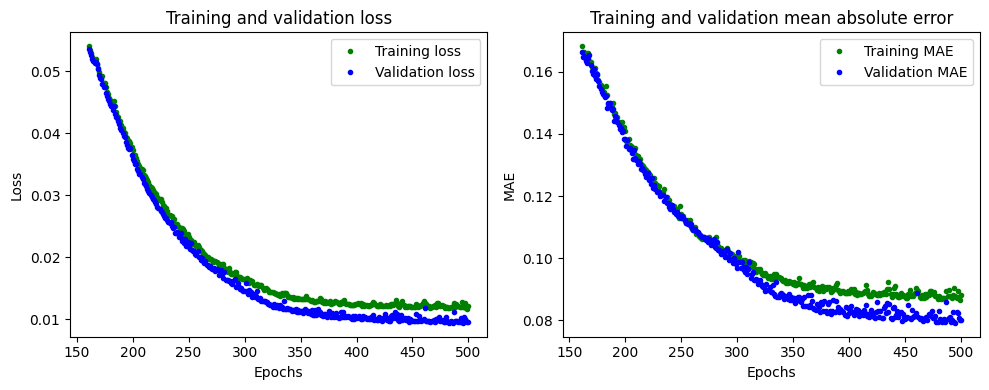

In [ ]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Exclude the first few epochs so the graph is easier to read
SKIP = 160

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction.
train_mae = history.history['mae']
val_mae = history.history['val_mae']

plt.plot(epochs[SKIP:], train_mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()

Great results! From these graphs, we can see several exciting things:

*   The overall loss and MAE are much better than our previous network
*   Metrics are better for validation than training, which means the network is not overfitting

The reason the metrics for validation are better than those for training is that validation metrics are calculated at the end of each epoch, while training metrics are calculated throughout the epoch, so validation happens on a model that has been trained slightly longer.

This all means our network seems to be performing well! To confirm, let's check its predictions against the test dataset we set aside earlier:


4/4 [==============================] - 0s 6ms/step


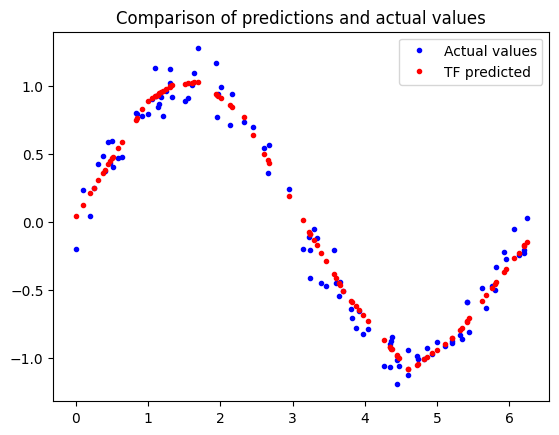

In [ ]:
# Calculate and print the loss on our test dataset
test_loss, test_mae = model.evaluate(x_test, y_test)

# Make predictions based on our test dataset
y_test_pred = model.predict(x_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual values')
plt.plot(x_test, y_test_pred, 'r.', label='TF predicted')
plt.legend()
plt.show()

Much better! The evaluation metrics we printed show that the model has a low loss and MAE on the test data, and the predictions line up visually with our data fairly well. For the most part, the dots representing *predicted* values form a
smooth curve along the center of the distribution of *actual* values. Our network has
learned to approximate a sine curve, even though the dataset was noisy!

The model isn't perfect; its predictions don't form a smooth sine curve. Variations in our training data, which is randomly distributed, have been learned by our model. This is a mild case of overfitting: instead of learning the
smooth sine function, our model has learned to replicate the exact shape of our data.

However, an important part of machine learning is *knowing when to stop*. For our purposes, this overfitting isn’t a major problem. Our goal is for this model to gently fade an LED on and off, and it doesn’t need to be perfectly smooth to achieve
this. If we thought the level of overfitting was problematic, we could attempt to
address it through regularization techniques, by obtaining more training data, or increasing the capacity of the model.


## Generating a TensorFlow Lite Model

At the beginning of this chapter we briefly touched on TensorFlow Lite, which is a set
of tools for running TensorFlow models on “edge devices”—meaning everything
from mobile phones down to microcontroller boards.

Chapter 13 goes into detail on TensorFlow Lite for Microcontrollers. For now, we can think of it as having two main components:

<ins>**TensorFlow Lite Converter**</ins>

This converts TensorFlow models into a special, space-efficient format for use on
memory-constrained devices, and it can apply optimizations that further reduce
the model size and make it run faster on small devices.

<ins>**TensorFlow Lite Interpreter**</ins>

This runs an appropriately converted TensorFlow Lite model using the most efficient operations for a given device.

Before we use our model with TensorFlow Lite, we need to convert it. We use the TensorFlow Lite Converter’s Python API to do this. It takes our Keras model and writes it to disk in the form of a **FlatBuffer**, which is a special file format designed to
be space-efficient. Because we’re deploying to devices with limited memory, this will come in handy! We’ll look at FlatBuffers in more detail in Chapter 12.

In addition to creating a FlatBuffer, the TensorFlow Lite Converter can also apply optimizations to the model. These optimizations generally reduce the size of the model, the time it takes to run, or both. This can come at the cost of a reduction in accuracy, but the reduction is often small enough that it’s worthwhile. You can read
more about optimizations in Chapter 13.

<ins>**Quantization**</ins>

One of the most useful optimizations is quantization. By default, the weights and biases in a model are stored as 32-bit floating-point numbers so that high-precision calculations can occur during training. Quantization allows you to reduce the precision
of these numbers so that they fit into 8-bit integers - a four times reduction in size.Even better, because it’s easier for a CPU to perform math with integers than with floats, a quantized model will run faster.

The coolest thing about quantization is that it often results in minimal loss in accuracy. This means that when deploying to low-memory devices, it is nearly always
worthwhile.

In the following cell, we'll convert the model twice: once with quantization, once without:

### Generate Models with or without Quantization

In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

# Define a generator function that provides our test data's x values
# as a representative dataset, and tell the converter to use it
def representative_dataset():
  for i in range(500):
    # Each scalar value must be inside of a 2D array that is wrapped in a list
    yield([x_train[i].reshape(1, 1)])
# Convert the model to the TensorFlow Lite format with quantization
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

3088

To create a quantized model that runs as efficiently as possible, we need to provide a representative dataset—a set of numbers that represent the full range of input values of the dataset on which the model was trained.

In the preceding cell, we can use our test dataset’s x values as a representative dataset. We define a function, `representative_dataset()`, that uses the yield operator to return them one by one.

To prove these models are still accurate after conversion and quantization, we use both of them to make predictions and compare these against our test results. Given that these are TensorFlow Lite models, we need to use the TensorFlow Lite interpreter
to do so.

Because it’s designed primarily for efficiency, the TensorFlow Lite interpreter is slightly more complicated to use than the Keras API. To make predictions with our Keras model, we could just call the `predict()` method, passing an array of inputs.

With TensorFlow Lite, we need to do the following:
1. Instantiate an Interpreter object.
2. Call some methods that allocate memory for the model.
3. Write the input to the input tensor.
4. Invoke the model.

This sounds like a lot, but don’t worry about it too much for now; we’ll walk through it in detail in Chapter 5. For now, run the following cell to make predictions with both models and plot them on a graph, alongside the results from our original, unconverted model:

**Helper functions**

We define the `predict` (for predictions) and `evaluate` (for loss) functions for TFLite models. *Note: These are already included in a TF model, but not in  a TFLite model

In [ ]:
def predict_tflite(tflite_model, x_test):
  # Prepare the test data
  x_test_ = x_test.copy()
  x_test_ = x_test_.reshape((x_test.size, 1))
  x_test_ = x_test_.astype(np.float32)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model,
                                    experimental_op_resolver_type=tf.lite.experimental.OpResolverType.BUILTIN_REF)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    x_test_ = x_test_ / input_scale + input_zero_point
    x_test_ = x_test_.astype(input_details["dtype"])

  # Invoke the interpreter
  y_pred = np.empty(x_test_.size, dtype=output_details["dtype"])
  for i in range(len(x_test_)):
    interpreter.set_tensor(input_details["index"], [x_test_[i]])
    interpreter.invoke()
    y_pred[i] = interpreter.get_tensor(output_details["index"])[0]

  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    y_pred = y_pred.astype(np.float32)
    y_pred = (y_pred - output_zero_point) * output_scale

  return y_pred

def evaluate_tflite(tflite_model, x_test, y_true):
  global model
  y_pred = predict_tflite(tflite_model, x_test)
  loss_function = tf.keras.losses.get(model.loss)
  loss = loss_function(y_true, y_pred).numpy()
  return loss

### Compare Modal Performances

In [ ]:
# Calculate predictions
y_test_pred_tf = model.predict(x_test)
y_test_pred_no_quant_tflite = predict_tflite(model_no_quant_tflite, x_test)
y_test_pred_tflite = predict_tflite(model_tflite, x_test)

4/4 [==============================] - 0s 6ms/step


<ipython-input-63-a01e28f362ba>:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[i] = interpreter.get_tensor(output_details["index"])[0]


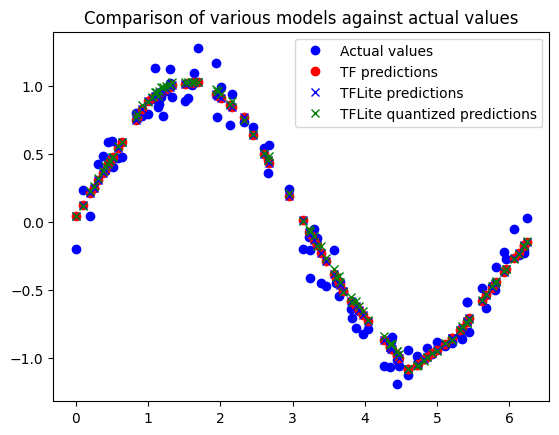

In [ ]:
# Compare predictions
plt.clf()
plt.title('Comparison of various models against actual values')
plt.plot(x_test, y_test, 'bo', label='Actual values')
plt.plot(x_test, y_test_pred_tf, 'ro', label='TF predictions')
plt.plot(x_test, y_test_pred_no_quant_tflite, 'bx', label='TFLite predictions')
plt.plot(x_test, y_test_pred_tflite, 'gx', label='TFLite quantized predictions')
plt.legend()
plt.show()

In [ ]:
# Calculate loss
loss_tf, _ = model.evaluate(x_test, y_test, verbose=0)
loss_no_quant_tflite = evaluate_tflite(model_no_quant_tflite, x_test, y_test)
loss_tflite = evaluate_tflite(model_tflite, x_test, y_test)

# Compare loss
df = pd.DataFrame.from_records(
    [["TensorFlow", loss_tf],
     ["TensorFlow Lite", loss_no_quant_tflite],
     ["TensorFlow Lite Quantized", loss_tflite]],
     columns = ["Model", "Loss/MSE"], index="Model").round(4)
df

<ipython-input-63-a01e28f362ba>:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[i] = interpreter.get_tensor(output_details["index"])[0]


,Loss/MSE
Model,
TensorFlow,0.0129
TensorFlow Lite,0.0129
TensorFlow Lite Quantized,0.0140


In [ ]:
# Calculate size
size_tf = os.path.getsize(MODEL_TF)
size_no_quant_tflite = os.path.getsize(MODEL_NO_QUANT_TFLITE)
size_tflite = os.path.getsize(MODEL_TFLITE)

# Compare size
pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")

,Size,
Model,,
TensorFlow,4096 bytes,
TensorFlow Lite,3232 bytes,(reduced by 864 bytes)
TensorFlow Lite Quantized,3088 bytes,(reduced by 144 bytes)


Our quantized model is 144 bytes smaller than the original version, which is great—but it’s only a minor reduction in size. At around 3KB, this model is already so small that the weights and biases make up only a fraction of the overall size. In addition to weights, the model contains all the logic that makes up the architecture of
our deep learning network, known as its **computation graph**. For truly tiny models, this can add up to more size than the model’s weights, meaning quantization has little effect.

More complex models have many more weights, meaning the space saving from quantization will be much higher. It can be expected to approach 4x for most sophisticated models.

Regardless of its exact size, our quantized model will take less time to execute than the original version, which is important on a tiny microcontroller.

### Converting to a C File

The final step in preparing our model for use with TensorFlow Lite for Microcontrollers is to convert it into a C source file that can be included in our application.

So far during this chapter, we’ve been using TensorFlow Lite’s Python API. This means that we’ve been able to use the Interpreter constructor to load our model files from disk.

However, most microcontrollers don’t have a filesystem, and even if they did, the extra code required to load a model from disk would be wasteful given our limited space. Instead, as an elegant solution, we provide the model in a C source file that can be included in our binary and loaded directly into memory.

In the file, the model is defined as an array of bytes. Fortunately, there’s a convenient Unix tool named **xxd** that is able to convert a given file into the required format.


In [ ]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

# Print the C source file
!cat {MODEL_TFLITE_MICRO}

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
unsigned char g_model[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x0

### Wrapping Up

And with that, we’re done building our model. We’ve trained, evaluated, and converted a TensorFlow deep learning network that can take a number between 0 and 2π and output a good-enough approximation of its sine.

This was our first taste of using Keras to train a tiny model. In future projects, we’ll be training models that are still tiny, but far more sophisticated.